In [1]:
import os
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt

In [2]:
# constants
channels = ['FC3', 'FCz', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CPz', 'CP4', 'P3', 'Pz', 'P4']
subject_id = ['15', '16', '17', '18']
sample_rate = 256
no_trials = 96
no_electrodes = len(channels)
epoch_length = int(sample_rate * 6.0)
pre_cue = int(sample_rate * 1.0)
save_preprocessed_epoch = True

data_path = 'dataset/'
save_path = 'results/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [3]:
# load the eeg data and their corresponding labels
classes = loadmat(data_path + 'labels.mat')['labels'][0]
print(classes.shape)
epochs = {}
correctness = {}
for sIdx, subject in enumerate(subject_id):
    epochs[sIdx] = loadmat(data_path + 'subject' + subject + '.mat')['EEGEpoch'].T
    correctness[sIdx] = classes[sIdx][0][0]
    print(epochs[sIdx].shape, correctness[sIdx].shape, np.mean(epochs[sIdx]))

(4,)
(96, 16, 1536) (96,) -0.00874230690635525
(96, 16, 1536) (96,) -0.005994115875539882
(96, 16, 1536) (96,) 0.013010918133830606
(96, 16, 1536) (96,) -0.03383564821055987


In [4]:
from scipy.signal import *
# 1. Apply a low-pass filter of your choice with a cut-off at 6Hz
b, a = butter(4, 6, btype='low', fs=sample_rate) 
filtered_eeg = {}
for sIdx, subject in enumerate(subject_id):
    filtered_eeg[sIdx] = np.zeros_like(epochs[sIdx])
    for tIdx in range(no_trials):
        filtered_eeg[sIdx][tIdx, :, :] = lfilter(b, a, epochs[sIdx][tIdx, :, :])
    print(filtered_eeg[sIdx].shape, np.mean(filtered_eeg[sIdx]))

(96, 16, 1536) -0.005322072376493025
(96, 16, 1536) -0.0020408885667119662
(96, 16, 1536) 0.010297753758550018
(96, 16, 1536) -0.030919531631647425


512 (512,)


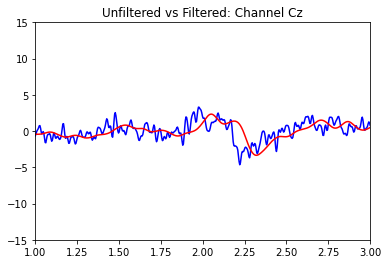

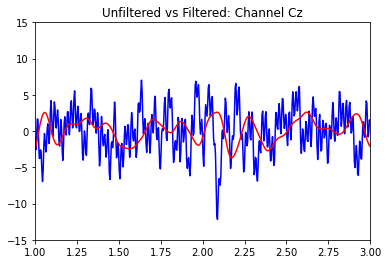

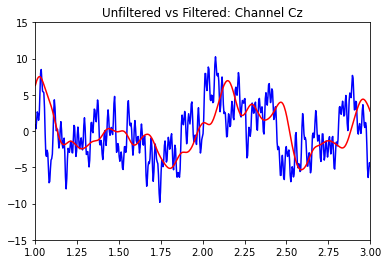

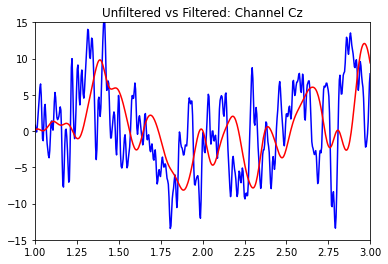

In [5]:
## 1b. Plot a sample of the filtered and raw eeg to compare the difference
## Testing with the 'Cz' electrode and fifth trial
t = np.linspace(1, 3, 2*256)
print(len(t), epochs[sIdx][5, 6, sample_rate*1:sample_rate*3].shape)
for sIdx, subject in enumerate(subject_id):
    plt.plot(t.T, epochs[sIdx][5, 6, sample_rate*1:sample_rate*3], 'b', label = 'unfiltered EEG')
    plt.plot(t.T, filtered_eeg[sIdx][5, 6, sample_rate*1:sample_rate*3], 'r', label = 'filtered EEG')
    plt.xlim([1, 3])
    plt.ylim([-15, 15])
    plt.title('Unfiltered vs Filtered: Channel %s' % channels[6])
    plt.show()

In [6]:
# 3. Apply a laplacian filter for the following electrodes: FCz, Cz and CPz
# The neighbors of the channels are as follows:
# a. FCz: FC3, FC4, Cz
# b. Cz: C3, FCz, C4, CPz
# c. CPz: CP3, Cz, CP4, Pz

# Neighbors for Laplacian
selected_channels = ['FCz', 'Cz', 'CPz']
neighbors_FCz = ['FC3', 'FC4', 'Cz']
neighbors_Cz = ['C3', 'FCz', 'C4', 'CPz']
neighbors_CPz = ['CP3', 'Cz', 'CP4', 'Pz']

spatial_filtered_epochs = {}
for sIdx in range(len(subject_id)):
    ep = filtered_eeg[sIdx]
    spatial_filtered_epochs[sIdx] = np.empty((np.asarray(ep).shape[0], len(selected_channels),
                                                     np.asarray(ep).shape[-1]))
    for c, channel in enumerate(selected_channels):
        for tIdx in range(no_trials):
            if channel == 'FCz':
                sig = ep[tIdx, channels.index(channel), :]
                n_sig = []
                for idx in neighbors_FCz:
                    n_sig.append(ep[tIdx, channels.index(idx), :])
                mean_sig = np.mean(n_sig)
                spatial_filtered_epochs[sIdx][tIdx, c, :] = (sig - mean_sig) * 1.0 / len(neighbors_FCz)
            elif channel == 'Cz':
                sig = ep[tIdx, channels.index(channel), :]
                n_sig = []
                for idx in neighbors_Cz:
                    n_sig.append(ep[tIdx, channels.index(idx), :])
                mean_sig = np.mean(n_sig)
                spatial_filtered_epochs[sIdx][tIdx, c, :] = (sig - mean_sig) * 1.0 / len(neighbors_Cz)
            elif channel == 'CPz':
                sig = ep[tIdx, channels.index(channel), :]
                n_sig = []
                for idx in neighbors_CPz:
                    n_sig.append(ep[tIdx, channels.index(idx), :])
                mean_sig = np.mean(n_sig)
                spatial_filtered_epochs[sIdx][tIdx, c, :] = (sig - mean_sig) * 1.0 / len(neighbors_CPz)
    print(spatial_filtered_epochs[sIdx].shape, np.mean(spatial_filtered_epochs[sIdx]))

(96, 3, 1536) 0.0011344804731038714
(96, 3, 1536) -0.0002476126002833254
(96, 3, 1536) -0.00033051464824363955
(96, 3, 1536) 0.0005727343305232544


512


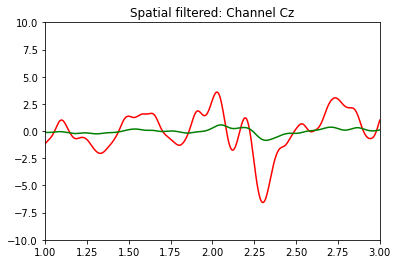

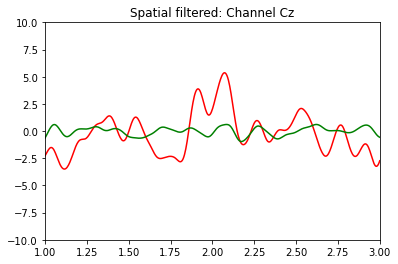

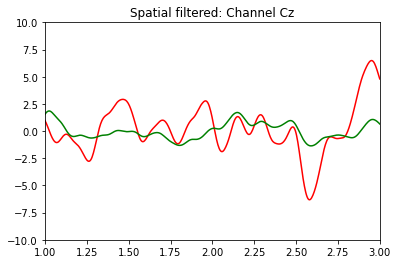

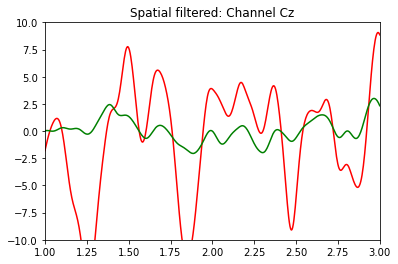

In [7]:
## 3b. Plot a sample of the filtered and raw eeg to compare the difference
## Testing with the 'Cz' electrode and fifth trial
t = np.linspace(1, 3, 2*256)
print(len(t))
for sIdx, subject in enumerate(subject_id):
    plt.plot(t.T, filtered_eeg[sIdx][5, 1, sample_rate*1:sample_rate*3], 'r', label = 'temporal-filtered EEG')
    plt.plot(t.T, spatial_filtered_epochs[sIdx][5, 1, sample_rate*1:sample_rate*3], 'g', label = 'spatial-filtered EEG')
    plt.xlim([1, 3])
    plt.ylim([-10, 10])
    plt.title('Spatial filtered: Channel %s' % channels[6])
    plt.show()

In [8]:
# 4a. Baseline correct the temporally filtered data
baseline_corrected_epochs = {}
for sIdx in range(len(subject_id)):
    ep2 = filtered_eeg[sIdx]
    baseline_corrected_epochs[sIdx] = np.empty((np.asarray(ep2).shape[0], len(selected_channels),
                                                              int(sample_rate * 1.5)))
    for trial in range(np.asarray(ep2).shape[0]):
        for c, channel in enumerate(selected_channels):
            baseline_region = ep2[trial, channels.index(channel), int(0.5 * sample_rate):int(1 * sample_rate)]
            roi_epoch = ep2[trial, c, int(1.5 * sample_rate):int(3 * sample_rate)]
            count = 0
            corrected = []
            while count < int(sample_rate * 1.5):
                corrected.extend(roi_epoch[count:count + len(baseline_region)] - baseline_region)
                count += len(baseline_region)
            baseline_corrected_epochs[sIdx][trial, c, :] = corrected
    print(baseline_corrected_epochs[sIdx].shape)

(96, 3, 384)
(96, 3, 384)
(96, 3, 384)
(96, 3, 384)


In [9]:
# 4b. Baseline correct the spatially filtered data
baseline_corrected_sepochs = {}
for sIdx in range(len(subject_id)):
    ep2 = spatial_filtered_epochs[sIdx]
    baseline_corrected_sepochs[sIdx] = np.empty((np.asarray(ep2).shape[0], len(selected_channels),
                                                              int(sample_rate * 1.5)))
    for trial in range(np.asarray(ep2).shape[0]):
        for c, channel in enumerate(selected_channels):
            baseline_region = ep2[trial, selected_channels.index(channel), int(0.5 * sample_rate):int(1 * sample_rate)]
            roi_epoch = ep2[trial, c, int(1.5 * sample_rate):int(3 * sample_rate)]
            count = 0
            corrected = []
            while count < int(sample_rate * 1.5):
                corrected.extend(roi_epoch[count:count + len(baseline_region)] - baseline_region)
                count += len(baseline_region)
            baseline_corrected_sepochs[sIdx][trial, c, :] = corrected
    print(baseline_corrected_sepochs[sIdx].shape)

(96, 3, 384)
(96, 3, 384)
(96, 3, 384)
(96, 3, 384)


In [10]:
# 5a. Calculate grand averages for the temporal filtered signal
ep_correct_sub = []
ep_incorrect_sub = []
fig = plt.figure(figsize=(14, 5))
for sIdx in range(len(subject_id)):
    X = baseline_corrected_epochs[sIdx]
    Y = correctness[sIdx]
    ep_correct = []
    ep_incorrect = []
    for tIdx in range(len(Y)):
        if Y[tIdx] == -1:
            ep_correct.append(detrend(X[tIdx], type='constant'))
        if Y[tIdx] == 1:
            ep_incorrect.append(detrend(X[tIdx], type='constant'))
    ep_correct_sub.append(np.mean(np.asarray(ep_correct), axis=0))
    ep_incorrect_sub.append(np.mean(np.asarray(ep_incorrect), axis=0))
    
print(np.asarray(ep_correct_sub).shape, np.asarray(ep_incorrect_sub).shape)
grand_averages_correct = np.mean(np.asarray(ep_correct_sub), axis=0)
grand_averages_incorrect = np.mean(np.asarray(ep_incorrect_sub), axis=0)
grand_averages_correct_std = np.std(np.asarray(ep_correct_sub), axis=0) / 2.5
grand_averages_incorrect_std = np.std(np.asarray(ep_incorrect_sub), axis=0) / 2.5
print(np.asarray(grand_averages_correct).shape, np.asarray(grand_averages_incorrect).shape)

save_plot = save_path + 'erps/'
if not os.path.exists(save_plot):
    os.mkdir(save_plot)

abscissas = np.linspace(0, 1.5, 384)
for c, channel in enumerate(selected_channels):
    plt.subplot(1, 3, c + 1)
    ax = fig.gca()
    p1 = ax.plot(abscissas, grand_averages_correct[selected_channels.index(channel), :], 'b-', label="Correct")
    p2 = ax.plot(abscissas, grand_averages_incorrect[selected_channels.index(channel), :], 'r-', label="Incorrect")
    p3 = ax.plot(abscissas, - grand_averages_correct[selected_channels.index(channel), :]
                 + grand_averages_incorrect[selected_channels.index(channel), :], 'k-.', label="Difference")
    plt.xlim((0, 1.5))
#     plt.ylim((-.5, .5))
#     plt.vlines(0.5, -5, 5, colors='k', linestyles='dashed', lw=1)
    if c == 0:
        plt.ylabel('EEG (mV)')
        plt.xlabel('Time (s)')
    plt.grid(b=False)
    lns = p1 + p2 + p3
    labs = [l.get_label() for l in lns]
    if c == 0:
        plt.legend(lns, labs, loc="upper left", ncol=2, fontsize=8)
        plt.ylabel('p-value')
    plt.plot([-0.5, 1.5], [.05, .05], 'k:', lw=1)
    plt.title(channel)
plt.tight_layout()
plt.savefig(save_plot + 'tfilter_grandAvg_combined.pdf')
plt.clf()

(4, 3, 384) (4, 3, 384)
(3, 384) (3, 384)


<Figure size 1008x360 with 0 Axes>

In [11]:
# 5a. Calculate grand averages for the spatially filtered signal
ep_correct_sub = []
ep_incorrect_sub = []
fig = plt.figure(figsize=(14, 5))
for sIdx in range(len(subject_id)):
    X = baseline_corrected_sepochs[sIdx]
    Y = correctness[sIdx]
    ep_correct = []
    ep_incorrect = []
    for tIdx in range(len(Y)):
        if Y[tIdx] == -1:
            ep_correct.append(detrend(X[tIdx], type='constant'))
        if Y[tIdx] == 1:
            ep_incorrect.append(detrend(X[tIdx], type='constant'))
    ep_correct_sub.append(np.mean(np.asarray(ep_correct), axis=0))
    ep_incorrect_sub.append(np.mean(np.asarray(ep_incorrect), axis=0))
    
print(np.asarray(ep_correct_sub).shape, np.asarray(ep_incorrect_sub).shape)
grand_averages_correct = np.mean(np.asarray(ep_correct_sub), axis=0)
grand_averages_incorrect = np.mean(np.asarray(ep_incorrect_sub), axis=0)
grand_averages_correct_std = np.std(np.asarray(ep_correct_sub), axis=0) / 2.5
grand_averages_incorrect_std = np.std(np.asarray(ep_incorrect_sub), axis=0) / 2.5
print(np.asarray(grand_averages_correct).shape, np.asarray(grand_averages_incorrect).shape)

save_plot = save_path + 'erps/'
if not os.path.exists(save_plot):
    os.mkdir(save_plot)

abscissas = np.linspace(0, 1.5, 384)
for c, channel in enumerate(selected_channels):
    plt.subplot(1, 3, c + 1)
    ax = fig.gca()
    p1 = ax.plot(abscissas, grand_averages_correct[selected_channels.index(channel), :], 'b-', label="Correct")
    p2 = ax.plot(abscissas, grand_averages_incorrect[selected_channels.index(channel), :], 'r-', label="Incorrect")
    p3 = ax.plot(abscissas, - grand_averages_correct[selected_channels.index(channel), :]
                 + grand_averages_incorrect[selected_channels.index(channel), :], 'k-.', label="Difference")
    plt.xlim((0, 1.5))
#     plt.ylim((-.5, .5))
#     plt.vlines(0.5, -5, 5, colors='k', linestyles='dashed', lw=1)
    if c == 0:
        plt.ylabel('EEG (mV)')
        plt.xlabel('Time (s)')
    plt.grid(b=False)
    lns = p1 + p2 + p3
    labs = [l.get_label() for l in lns]
    if c == 0:
        plt.legend(lns, labs, loc="upper left", ncol=2, fontsize=8)
        plt.ylabel('p-value')
    plt.plot([-0.5, 1.5], [.05, .05], 'k:', lw=1)
    plt.title(channel)
plt.tight_layout()
plt.savefig(save_plot + 'sfilter_grandAvg_combined.pdf')
plt.clf()

(4, 3, 384) (4, 3, 384)
(3, 384) (3, 384)


<Figure size 1008x360 with 0 Axes>

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


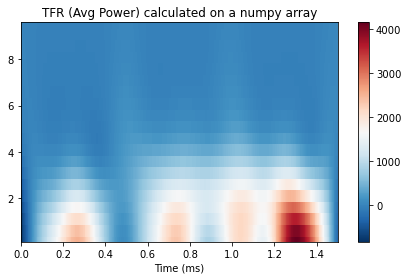

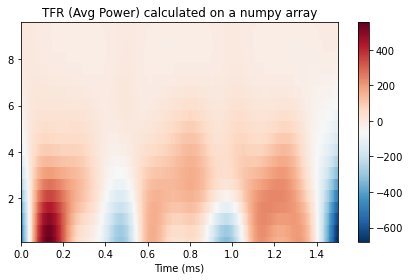

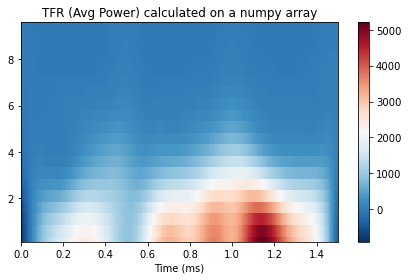

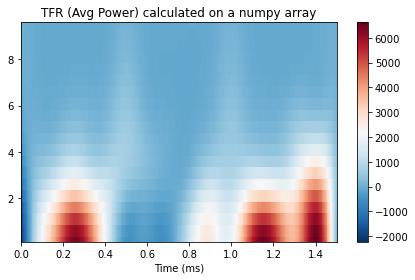

In [12]:
## Time-Frequency analysis on temporally fitered data using mne toolbox
## Average Power
from mne.time_frequency import tfr_array_morlet
from mne.baseline import rescale
from mne.viz import centers_to_edges

freqs = np.arange(.1, 10., .5)
n_cycles = freqs / 2.
times = np.linspace(0, 1.5, 384)

for sIdx in range(len(subject_id)): 
    power = tfr_array_morlet(baseline_corrected_epochs[sIdx], sfreq=sample_rate, 
                                   freqs=freqs, n_cycles=n_cycles, output='avg_power')
    # Baseline the output
    rescale(power, times, (0., 0.1), mode='mean', copy=False)
    fig, ax = plt.subplots()
    x, y = centers_to_edges(times, freqs)
    mesh = ax.pcolormesh(x, y, power[0], cmap='RdBu_r') # 
    ax.set_title('TFR (Avg Power) calculated on a numpy array')
    ax.set(ylim=freqs[[0, -1]], xlabel='Time (ms)')
    fig.colorbar(mesh)
    plt.tight_layout()

plt.show()

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


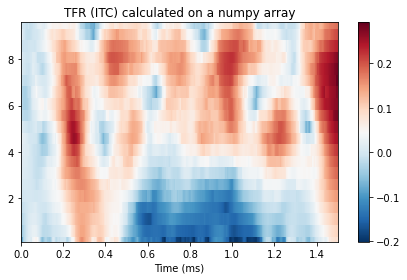

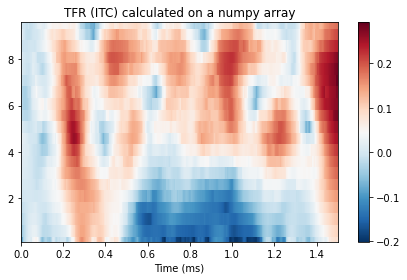

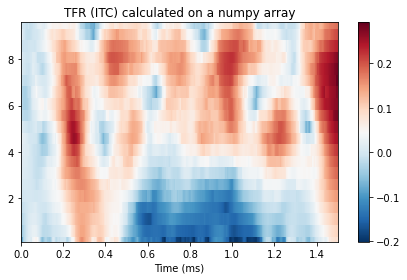

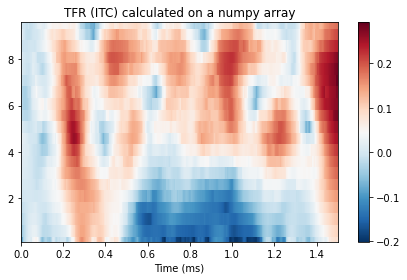

In [13]:
## Time-Frequency analysis on temporally fitered data using mne toolbox
## Inter-trial Coherence
freqs = np.arange(.1, 10., .5)
n_cycles = freqs / 2.
times = np.linspace(0, 1.5, 384)

for sIdx in range(len(subject_id)):  
    itc = tfr_array_morlet(baseline_corrected_epochs[0], sfreq=sample_rate, freqs=freqs, 
                           n_cycles=n_cycles, output='itc')

    # Baseline the output
    rescale(itc, times, (0., 0.1), mode='mean', copy=False)
    fig, ax = plt.subplots()
    x, y = centers_to_edges(times, freqs)
    mesh = ax.pcolormesh(x, y, itc[0], cmap='RdBu_r') # 
    ax.set_title('TFR (ITC) calculated on a numpy array')
    ax.set(ylim=freqs[[0, -1]], xlabel='Time (ms)')
    fig.colorbar(mesh)
    plt.tight_layout()

plt.show()

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


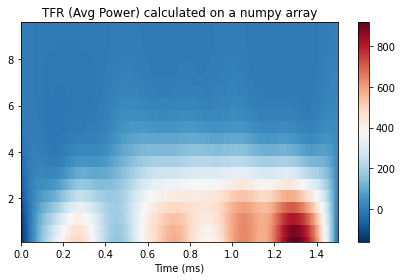

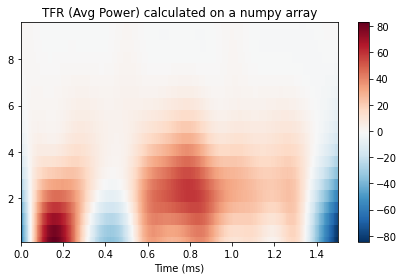

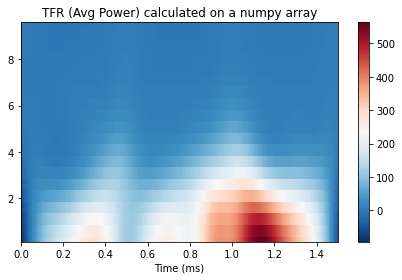

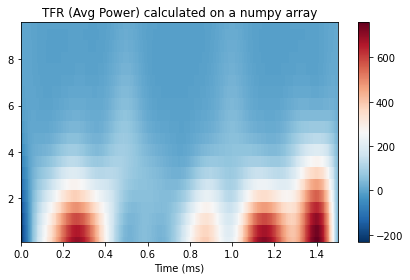

In [14]:
## Time-Frequency analysis on spatially fitered data using mne toolbox
## Average Power
from mne.time_frequency import tfr_array_morlet
from mne.baseline import rescale
from mne.viz import centers_to_edges

freqs = np.arange(.1, 10., .5)
n_cycles = freqs / 2.
times = np.linspace(0, 1.5, 384)

for sIdx in range(len(subject_id)): 
    power = tfr_array_morlet(baseline_corrected_sepochs[sIdx], sfreq=sample_rate, 
                                   freqs=freqs, n_cycles=n_cycles, output='avg_power')
    # Baseline the output
    rescale(power, times, (0., 0.1), mode='mean', copy=False)
    fig, ax = plt.subplots()
    x, y = centers_to_edges(times, freqs)
    mesh = ax.pcolormesh(x, y, power[0], cmap='RdBu_r') # 
    ax.set_title('TFR (Avg Power) calculated on a numpy array')
    ax.set(ylim=freqs[[0, -1]], xlabel='Time (ms)')
    fig.colorbar(mesh)
    plt.tight_layout()

plt.show()

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


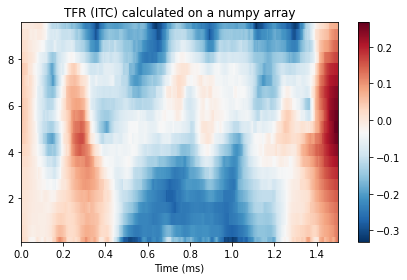

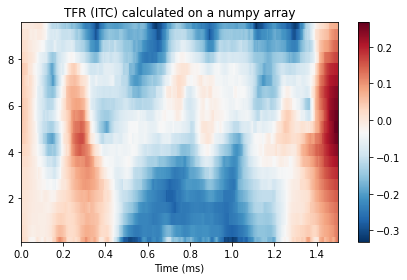

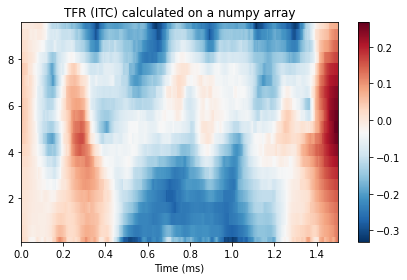

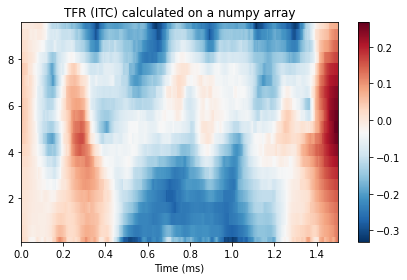

In [15]:
## Time-Frequency analysis on spatially fitered data using mne toolbox
## Inter-trial Coherence
freqs = np.arange(.1, 10., .5)
n_cycles = freqs / 2.
times = np.linspace(0, 1.5, 384)

for sIdx in range(len(subject_id)):  
    itc = tfr_array_morlet(baseline_corrected_sepochs[0], sfreq=sample_rate, freqs=freqs, 
                           n_cycles=n_cycles, output='itc')

    # Baseline the output
    rescale(itc, times, (0., 0.1), mode='mean', copy=False)
    fig, ax = plt.subplots()
    x, y = centers_to_edges(times, freqs)
    mesh = ax.pcolormesh(x, y, itc[0], cmap='RdBu_r') # 
    ax.set_title('TFR (ITC) calculated on a numpy array')
    ax.set(ylim=freqs[[0, -1]], xlabel='Time (ms)')
    fig.colorbar(mesh)
    plt.tight_layout()

plt.show()